In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split,cross_val_score
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
import gensim
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pdb
import re
from sklearn.neighbors import KNeighborsClassifier
import seaborn as sb
from sklearn.naive_bayes import GaussianNB

C:\Users\admin\AppData\Local\Programs\Python\Python36\Lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [2]:
df=pd.read_csv(".\\reviews.csv")

In [4]:
print(df.shape)
print(df.columns)

(568454, 10)
Index(['Id', 'ProductId', 'UserId', 'ProfileName', 'HelpfulnessNumerator',
       'HelpfulnessDenominator', 'Score', 'Time', 'Summary', 'Text'],
      dtype='object')


In [5]:
df.head(1)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...


In [6]:
print(df.shape)
df.dropna(inplace=True)
df=df[df.Score != 3]
positive_or_negative=lambda a: "positive" if ((type(a)== type(2)) and (a > 3)) else "negative"
df['Score']=df['Score'].map(positive_or_negative)
df= df[df.HelpfulnessNumerator<=df.HelpfulnessDenominator]
df.shape

(568454, 10)


(525771, 10)

In [7]:
##soring data according product id
df_sorted=df.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

##deduplication of entries
final=df_sorted.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]


print(final.shape)

#check how much data is present, len(final['ProductId'])
(final['ProductId'].size*1.0/df['ProductId'].size*1.0)*100

(364159, 10)


69.26190299579095

In [8]:
final['Score'].value_counts()

positive    307054
negative     57105
Name: Score, dtype: int64

In [9]:
##text processing
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

stop = set(stopwords.words('english')) #set of stopwords
sno = nltk.stem.SnowballStemmer('english') #initialising the snowball stemmer

#print(stop)
print('************************************')
print(sno.stem('tasty'))

************************************
tasti


In [10]:
##split data

df_sorted=final.sort_values('Time')
print(df_sorted.shape)


(364159, 10)


In [11]:
#Code for implementing step-by-step the checks mentioned in the pre-processing phase
# this code takes a while to run as it needs to run on 500k sentences.
##finding sentense vector for test
##cleaning sentense
##making sentenses list, each sentense list has words
def cleanhtml(sentence): #function to clean the word of any html-tags
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext
def cleanpunc(sentence): #function to clean the word of any punctuation or special characters
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned


def cleaning(df):
    print("no of sentenses in set %d"%(len(df)))
    list_sentenses=[]
    for sent in df:
        final_sentence=''
        sent=cleanhtml(sent)
        filtered_sentense=[]
        for w in sent.split():
            for cleaned_words in cleanpunc(w).split():
                if (cleaned_words.isalpha()):
                    filtered_sentense.append(cleaned_words.lower())
            else:
                continue 
        final_sentence=' '.join(filtered_sentense)
        list_sentenses.append(final_sentence)
    return list_sentenses


In [12]:
df_processed_sorted=pd.DataFrame({'label':df_sorted['Score']})
df_processed_sorted['text']= cleaning(df_sorted['Text'])


no of sentenses in set 364159


In [36]:
print(df_processed_sorted.head(2))

           label                                               text
150523  positive  this witty little book makes my son laugh at l...
150500  positive  i can remember seeing the show when it aired o...


In [37]:
##picking, processed data to file before feature extraction

df_processed_sorted.to_pickle('.\pickles\df_processed_sorted')

# BOW####

In [4]:
##getting data from pickle
df_processed_sorted=pd.read_pickle('.\pickles\df_processed_sorted')
print(df_processed_sorted.head(2))
df_processed_sorted.shape

           label                                               text
150523  positive  this witty little book makes my son laugh at l...
150500  positive  i can remember seeing the show when it aired o...


(364159, 2)

In [5]:
size=int(df_processed_sorted.shape[0]*0.7)
print(size)
df_train=df_processed_sorted.iloc[:size,:]
df_test=df_processed_sorted.iloc[size:,:]
print(df_train.shape,df_test.shape)
df_train= df_train.sample(frac=0.01)
df_test= df_test.sample(frac=0.01)
print("after sampling train and test sizes",df_train.shape,df_test.shape)

254911
(254911, 2) (109248, 2)
after sampling train and test sizes (2549, 2) (1092, 2)


In [ ]:
# Verifying balanced data set or not

In [8]:
df_train.head(1)
y_train=df_train['label']
y_test=df_test['label']
#print(y_train.value_counts)
y_train.value_counts()


positive    2168
negative     381
Name: label, dtype: int64

In [9]:
#from sklearn.feature_extraction.text import CountVectorizer

bow=CountVectorizer(stop_words="english", ngram_range=(1,3))
bow_train=bow.fit_transform(df_train['text'])
bow_test=bow.transform(df_test['text'])


print(type(bow_train))
print(bow_train.shape,bow_test.shape)

<class 'scipy.sparse.csr.csr_matrix'>
(2549, 162997) (1092, 162997)


In [23]:
'''
from scipy import sparse

sparse.save_npz("bow_sparse_train.npz", bow_train)
bow_train_loaded = sparse.load_npz("bow_sparse_train.npz")
print(type(bow_train_loaded))
print(bow_train_loaded.shape)

sparse.save_npz("bow_sparse_test.npz", bow_test)
bow_test_loaded = sparse.load_npz("bow_sparse_test.npz")
print(type(bow_test_loaded))
print(bow_test_loaded.shape)
'''

'\nfrom scipy import sparse\n\nsparse.save_npz("bow_sparse_train.npz", bow_train)\nbow_train_loaded = sparse.load_npz("bow_sparse_train.npz")\nprint(type(bow_train_loaded))\nprint(bow_train_loaded.shape)\n\nsparse.save_npz("bow_sparse_test.npz", bow_test)\nbow_test_loaded = sparse.load_npz("bow_sparse_test.npz")\nprint(type(bow_test_loaded))\nprint(bow_test_loaded.shape)\n'

In [10]:
##getting k value using k fold
import matplotlib.pyplot as plt

neighbours=list(range(1,50,2))

cv_scores=[]
for k in neighbours:
    knn=KNeighborsClassifier(n_neighbors=k)
    scores=cross_val_score(knn,bow_train,y_train,cv=10)
    #print(scores)
    cv_scores.append(scores.mean())
MSE= [1-i for i in cv_scores]

In [28]:
print(MSE)

[0.28943822853944723, 0.1620117700131234, 0.1545622129265093, 0.15613240842596876, 0.1545668326385672, 0.15456837656322375, 0.154174675775822, 0.154174675775822, 0.154174675775822, 0.154174675775822, 0.154174675775822, 0.154174675775822, 0.154174675775822, 0.154174675775822, 0.154174675775822, 0.154174675775822, 0.154174675775822, 0.154174675775822, 0.154174675775822, 0.154174675775822, 0.154174675775822, 0.154174675775822, 0.154174675775822, 0.154174675775822, 0.154174675775822]


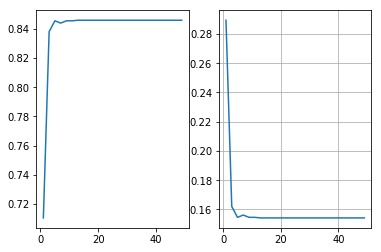

In [30]:
plt.figure(1)
plt.subplot(1,2,1)
plt.plot(neighbours,cv_scores)
plt.subplot(1,2,2)
plt.plot(neighbours,MSE)
plt.grid()
plt.show()


In [11]:
#min(MSE)
print(MSE)
print("minimum MSE value",min(MSE))
ind=MSE.index(min(MSE))
optimal_k=neighbours[ind]
print("optimal k value is..",optimal_k)

[0.18909884253898412, 0.1628134890767331, 0.15417678661031342, 0.1498615171954608, 0.14946936033271574, 0.14946936033271574, 0.14946936033271574, 0.14946936033271574, 0.14946936033271574, 0.14946936033271574, 0.14946936033271574, 0.14946936033271574, 0.14946936033271574, 0.14946936033271574, 0.14946936033271574, 0.14946936033271574, 0.14946936033271574, 0.14946936033271574, 0.14946936033271574, 0.14946936033271574, 0.14946936033271574, 0.14946936033271574, 0.14946936033271574, 0.14946936033271574, 0.14946936033271574]
minimum MSE value 0.14946936033271574
optimal k value is.. 9


# training with KNN

In [12]:
from sklearn.metrics import accuracy_score,confusion_matrix,precision_score,precision_recall_curve
print(bow_train.shape,y_train.shape,bow_test.shape,y_test.shape)
knn=KNeighborsClassifier(n_neighbors=optimal_k)
knn.fit(bow_train,y_train)
pred=knn.predict(bow_test)
accuracy=accuracy_score(y_test,pred)
print("the accuracy of KNN on BOW data is %f"%(accuracy) )

(2549, 162997) (2549,) (1092, 162997) (1092,)
the accuracy of KNN on BOW data is 0.828755


# training with kd tree

In [13]:
##find optimal k for kdtree, using gridSerachCV
from sklearn.model_selection import GridSearchCV
kdtree_model=KNeighborsClassifier(n_neighbors=optimal_k)
neighbours=list(range(1,50,2))
param_grid = {'n_neighbors':neighbours}
grid = GridSearchCV(kdtree_model, param_grid,cv=10,scoring = 'accuracy')

grid.fit(bow_train,y_train)
print(grid.best_params_)




{'n_neighbors': 9}


In [14]:
optimal_k=grid.best_params_['n_neighbors']
optimal_k

9

In [15]:
knn=KNeighborsClassifier(n_neighbors=optimal_k,algorithm='kd_tree')
knn.fit(bow_train,y_train)
pred=knn.predict(bow_test)
accuracy=accuracy_score(y_test,pred)
print("the accuracy of KNN on BOW data is %f"%(accuracy) )

the accuracy of KNN on BOW data is 0.828755


C:\Users\admin\AppData\Local\Programs\Python\Python36\Lib\site-packages\sklearn\neighbors\base.py:212: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: "


In [56]:
knn=KNeighborsClassifier(n_neighbors=optimal_k,algorithm='ball_tree')
knn.fit(bow_train,y_train)
pred=knn.predict(bow_test)
accuracy=accuracy_score(y_test,pred)
print("the accuracy of KNN on BOW data is %f"%(accuracy) )

the accuracy of KNN on BOW data is 0.830586


C:\Users\admin\AppData\Local\Programs\Python\Python36\Lib\site-packages\sklearn\neighbors\base.py:212: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: "


In [57]:
knn=KNeighborsClassifier(n_neighbors=optimal_k,algorithm='auto')
knn.fit(bow_train,y_train)
pred=knn.predict(bow_test)
accuracy=accuracy_score(y_test,pred)
print("the accuracy of KNN on BOW data is %f"%(accuracy) )

the accuracy of KNN on BOW data is 0.830586


In [16]:
##printing performace metrics
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test,pred)


array([[  0, 187],
       [  0, 905]], dtype=int64)

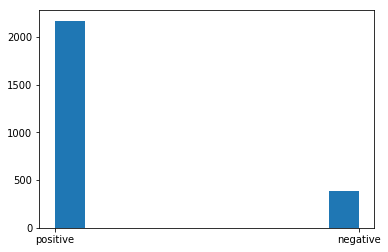

In [28]:
#print(df_train.label.head(1))

df_train.label.value_counts()
plt.figure(1)
plt.hist(df_train.label.tolist())
plt.show()


# Naive bayes

In [33]:
from sklearn.naive_bayes import BernoulliNB
neighbours=list(range(1,50,2))
param_grid = {'alpha':[0.00001, 0.0001, 0.001, 0.1, 1, 10, 100,1000]}
grid = GridSearchCV(BernoulliNB(), param_grid,cv=10,scoring = 'accuracy')
grid.fit(bow_train,y_train)
print(grid.best_params_)

{'alpha': 10}


In [111]:
from sklearn.naive_bayes import MultinomialNB

#optimal_alpha=grid.best_params_['alpha']
BernouliNB_model=BernoulliNB(alpha=10)
#MultinominalNB_model=MultinomialNB(alpha=optimal_alpha)
BernouliNB_model.fit(bow_train,df_train.label)
pred=BernouliNB_model.predict(bow_test)
accuracy=accuracy_score(y_test,pred)
print("the accuracy of naivey bayes on BOW data is %f"%(accuracy) )

the accuracy of naivey bayes on BOW data is 0.828755


# linear SVC

In [75]:
##using linear svc
from sklearn.linear_model import SGDClassifier
from sklearn.svm import SVC,LinearSVC
C = [10 ** x for x in range(-5, 1)]
param_grid = {'C':alpha}
grid = GridSearchCV(LinearSVC(class_weight='balanced'), param_grid,cv=10,scoring = 'accuracy')
grid.fit(bow_train,y_train)
print(grid.best_params_)
best_C=grid.best_params_['C']

{'C': 0.01}


In [88]:
svc= LinearSVC(C=best_C,random_state=42,class_weight='balanced')
svc.fit(bow_train,df_train.label)
pred=svc.predict(bow_test)
print(pred)
accuracy_score(y_test,pred)
print("the accuracy of linear svc on BOW data is %f"%(accuracy) )

['positive' 'positive' 'positive' ... 'positive' 'negative' 'positive']
the accuracy of naivey bayes on BOW data is 0.828755


In [1]:
print(confusion_matrix(y_test,pred))

NameError: name 'confusion_matrix' is not defined

# logistic regression

In [93]:
####logistic regression
from sklearn.linear_model import LogisticRegression
C = [10 ** x for x in range(-6, 3)]
param_grid = {'C':alpha}
grid = GridSearchCV(LogisticRegression(class_weight='balanced'), param_grid,cv=10,scoring = 'accuracy')
grid.fit(bow_train,y_train)
print(grid.best_params_)
best_C=grid.best_params_['C']

{'C': 0.1}


In [94]:
svc= LogisticRegression(C=best_C,random_state=42,class_weight='balanced')
svc.fit(bow_train,df_train.label)
pred=svc.predict(bow_test)
print(pred)
accuracy_score(y_test,pred)
print("the accuracy of logistic regression on BOW data is %f"%(accuracy) )

['positive' 'positive' 'positive' ... 'positive' 'negative' 'positive']
the accuracy of logistic regression on BOW data is 0.828755


In [95]:
print(confusion_matrix(y_test,pred))

[[103  84]
 [ 42 863]]


In [ ]:
##RBF SVC

In [108]:
#http://scikit-learn.org/stable/auto_examples/svm/plot_rbf_parameters.html
from sklearn.svm import SVC
from sklearn.model_selection import RandomizedSearchCV
#C_range = np.logspace(-2, 10, 13)
#gamma_range = np.logspace(-9, 3, 13)
param_grid={'C':C_range,'gamma':gamma_range}
C_range = [10 ** x for x in range(-2, 2)]
gamma_range = [10 ** x for x in range(-2, 2)]
grid = RandomizedSearchCV(SVC(class_weight='balanced'), param_grid,cv=10,scoring = 'accuracy')
grid.fit(bow_train,y_train)
print(grid.best_params_)



{'gamma': 0.01, 'C': 0.0001}


In [109]:
C_best=grid.best_params_['C']
gamma_best=grid.best_params_['gamma']
svc= SVC(C=best_C,gamma=gamma_best,random_state=42,class_weight='balanced')
svc.fit(bow_train,df_train.label)
pred=svc.predict(bow_test)
print(pred)
accuracy_score(y_test,pred)
print("the accuracy of RBF svc on BOW data is %f"%(accuracy) )
print(confusion_matrix(y_test,pred))

['positive' 'positive' 'positive' ... 'positive' 'positive' 'positive']
the accuracy of RBF svc on BOW data is 0.828755
[[ 43 144]
 [145 760]]


# Decision Tree Classifier